In [165]:
from xgboost import XGBClassifier
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_curve, auc, f1_score, confusion_matrix, make_scorer, precision_score, recall_score
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import math
from imblearn.over_sampling import RandomOverSampler

In [166]:
# Data train
train_bio_ave = pd.read_csv('../../Data/Data_2024/Environnemental_Data/train/GLC24-PA-train-bioclimatic-average.csv')
train_elev = pd.read_csv('../../Data/Data_2024/Environnemental_Data/train/GLC24-PA-train-elevation.csv')
train_human = pd.read_csv('../../Data/Data_2024/Environnemental_Data/train/GLC24-PA-train-human-footprint.csv')
train_land = pd.read_csv('../../Data/Data_2024/Environnemental_Data/train/GLC24-PA-train-landcover.csv')
train_soilgrid = pd.read_csv('../../Data/Data_2024/Environnemental_Data/train/GLC24-PA-train-soilgrids.csv')

abio = train_bio_ave.merge(train_elev, on='surveyId')\
        .merge(train_human, on='surveyId')\
                .merge(train_land, on='surveyId')\
                    .merge(train_soilgrid, on='surveyId')
                    
abio = abio.replace([np.inf], np.nan)
abio = abio.replace([-np.inf], np.nan)
abio = abio.fillna(abio.mean())


# Data TEST
test_bio_ave = pd.read_csv('../../Data/Data_2024/Environnemental_Data/test/GLC24-PA-test-bioclimatic-average.csv')
test_elev = pd.read_csv('../../Data/Data_2024/Environnemental_Data/test/GLC24-PA-test-elevation.csv')
test_human = pd.read_csv('../../Data/Data_2024/Environnemental_Data/test/GLC24-PA-test-human-footprint.csv')
test_land = pd.read_csv('../../Data/Data_2024/Environnemental_Data/test/GLC24-PA-test-landcover.csv')
test_soilgrid = pd.read_csv('../../Data/Data_2024/Environnemental_Data/test/GLC24-PA-test-soilgrids.csv')

abiotest = test_bio_ave.merge(test_elev, on='surveyId')\
        .merge(test_human, on='surveyId')\
                .merge(test_land, on='surveyId')\
                    .merge(test_soilgrid, on='surveyId')
                    
                    
# Listes espèces
species = pd.read_csv('../../Data/Data_2024/GLC24-PA-metadata-train.csv')
species['speciesId'] = species['speciesId'].astype(int)

In [167]:
acp_biotest = pd.read_csv('../../../Data_TER/feature/coord_acp_bioclim_test78va.csv')
acp_biotrain = pd.read_csv('../../../Data_TER/feature/coord_acp_bioclim_train78va.csv')
acp_landtest = pd.read_csv('../../../Data_TER/feature/coord_acp_landsat_test153va.csv')
acp_landtrain = pd.read_csv('../../../Data_TER/feature/coord_acp_landsat_train153va.csv')

In [168]:
abio = acp_biotrain.merge(acp_landtrain, on='surveyId')
abiotest = acp_biotest.merge(acp_landtest, on='surveyId')

In [170]:
abio.shape

(88987, 232)

In [7]:
species_patch = species.groupby('speciesId')['surveyId'].agg(list).reset_index()

#Liste présence/absence
presence = []
for i in range(len(species_patch)):
    survey_id = species_patch['surveyId'].iloc[i]
    species_id = species_patch['speciesId'].iloc[i]
    # Pour chaque espèce on stock 0 ou 1 pour chaqeu surveyId
    presence_espece = abio['surveyId'].isin(survey_id).astype(int)
    # On rassemble les présences de toutes les espèces dans une liste
    presence.append((str(species_id), presence_espece))
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

# Jeu de données

In [193]:
X = abio.iloc[:,1:].values
Y = presence[22][1]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=42)

In [205]:
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

In [107]:
y_resampled.sum()

53391

# Optimisation des hyperparamètres

### Test avec une espèce

In [192]:
ind = len(presence[5][1])
minoritaire = presence[22][1].sum()
weight = (ind - minoritaire) / minoritaire
minoritaire

132

In [5]:
math.ceil(2+(presence[4][1].sum()*1000/len(presence[4][1])))

5

In [11]:
model = XGBClassifier()
param_grid = {
    'scale_pos_weight': [1,10,100],
    'learning_rate': [0.1,0.5], 
    'max_depth': [2,5,10], 
    'n_estimators': [500], 
    'min_child_weight': [2,4],
    'reg_alpha': [0, 0.5],  
    'reg_lambda': [0, 0.5]
}

weighted_f1_scorer = make_scorer(f1_score, average='weighted')
grid_search = GridSearchCV(model, param_grid, scoring=weighted_f1_scorer, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

KeyboardInterrupt: 

In [205]:
print(grid_search.best_params_, grid_search.best_score_)

{'learning_rate': 0.5, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 100, 'reg_alpha': 1, 'reg_lambda': 0, 'scale_pos_weight': 50} 0.9963672261416101


### Meilleur classifieur

In [215]:
#scale_pos_weight=best_params['scale_pos_weight'],
#best_params = grid_search.best_params_
xgb = XGBClassifier(
                    learning_rate=0.5,
                    max_depth=5,
                    n_estimators=500,
                    min_child_weight=4,
                    reg_alpha=1,
                    reg_lambda=1)

In [216]:
xgb.fit(X_resampled, y_resampled)
#xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.5, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=4, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [217]:
y_pred = xgb.predict(X_test)

TP = sum((y_pred == 1) & (y_test == 1))
FP = sum((y_pred == 1) & (y_test == 0))
TN = sum((y_pred == 0) & (y_test == 0))
FN = sum((y_pred == 0) & (y_test == 1))

print("Vrais Positifs:", TP, "    |    Faux Positifs:", FP, "     |    Vrais Négatifs:", TN, "     |    Faux Négatifs:", FN)

Vrais Positifs: 40     |    Faux Positifs: 36      |    Vrais Négatifs: 35503      |    Faux Négatifs: 16


In [218]:
precision_score(y_test,y_pred)

0.5263157894736842

# Boucle model

In [78]:
predict={}

XTEST = abiotest.iloc[:,1:].values
XTRAIN = abio.iloc[:,1:].values

In [285]:
%%time

#Model pour un individu
model = XGBClassifier()
param_grid = {
    'learning_rate': [0.1,0.5,1],
    'max_depth': [2,5,10],
    'n_estimators': [100],
    'min_child_weight' : [2,4],
    'reg_alpha': [0, 0.1],  
    'reg_lambda': [0, 0.1]
}

for i in range(len(species_patch)):
    
    YTRAIN = presence[i][1]
    ind = len(YTRAIN)
    minoritaire = YTRAIN.sum()
    
    if YTRAIN.sum() > 2:
        # On cherche les meilleurs paramètres
        cv = math.ceil(2+(minoritaire*1000/ind))
        grid_search = GridSearchCV(model, param_grid, scoring='roc_auc', cv=cv, n_jobs=-1)
        grid_search.fit(XTRAIN, YTRAIN)
    
        # Modèle avec poids
        xgb = XGBClassifier(scale_pos_weight=(ind - minoritaire) / minoritaire,
                            learning_rate=grid_search.best_params_['learning_rate'],
                            max_depth=grid_search.best_params_['max_depth'],
                            n_estimators=grid_search.best_params_['n_estimators'],
                            min_child_weight=grid_search.best_params_['min_child_weight'],
                            reg_alpha=grid_search.best_params_.get('reg_alpha', 0),
                            reg_lambda=grid_search.best_params_.get('reg_lambda', 1))
        
        # Séparation pour trouver seuil
        X_train, X_test, y_train, y_test = train_test_split(XTRAIN, YTRAIN, test_size=0.3, random_state=42)
        xgb.fit(X_train, y_train)
        y_pred = xgb.predict_proba(X_test)[:,1]
        fpr, tpr, seuils = roc_curve(y_test, y_pred)    
        seuil = seuils[np.argmin(np.sqrt(fpr**2 + (1-tpr)**2))]
        
        # Prédiction
        xgb.fit(XTRAIN, YTRAIN)
        YPRED = (xgb.predict_proba(XTEST)[:,1] > seuil).astype(int)
    
    else:
        # Modèle avec poids
        xgb_unique = XGBClassifier(scale_pos_weight=(ind - minoritaire) / minoritaire, 
                                   learning_rate=0.1,
                                   max_depth=2,
                                   min_child_weight= 2,
                                   n_estimators=100,
                                   reg_alpha= 0.1)
        #Seuil
        X_train, X_test, y_train, y_test = train_test_split(XTRAIN, YTRAIN, test_size=0.3, random_state=42)
        xgb_unique.fit(X_train, y_train)
        y_pred = xgb_unique.predict_proba(X_test)[:,1]
        fpr, tpr, seuils = roc_curve(y_test, y_pred)    
        seuil = seuils[np.argmin(np.sqrt(fpr**2 + (1-tpr)**2))]
        
        # Prédiction
        xgb_unique.fit(XTRAIN, YTRAIN)
        YPRED = (xgb_unique.predict_proba(XTEST)[:,1] > seuil).astype(int)
         
    predict[presence[i][0]] = YPRED
    print(i)
    
pa_xgb = pd.DataFrame(predict)
pa_xgb.to_csv("XGB_100_roc.csv", index=False, sep=',')

0


c:\Users\mbrei\anaconda3\Lib\site-packages\sklearn\metrics\_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


1
2
3
4
5
6
7
8
9


c:\Users\mbrei\anaconda3\Lib\site-packages\sklearn\metrics\_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


10


c:\Users\mbrei\anaconda3\Lib\site-packages\sklearn\metrics\_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


11
12
13


KeyboardInterrupt: 

# Optimisation du seuil de décision

In [219]:
predict_prob = xgb.predict_proba(X_test)[:, 1]

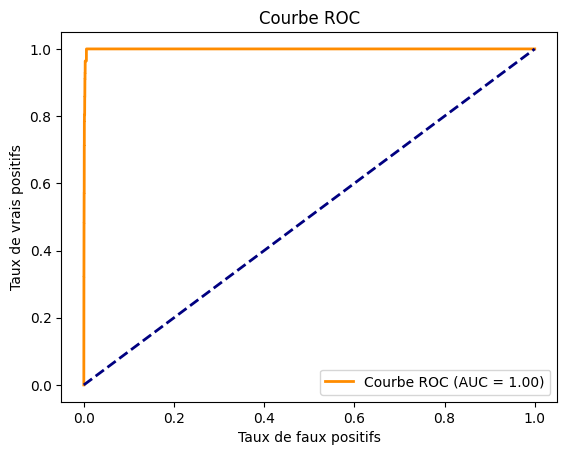

In [220]:
fpr, tpr, seuils = roc_curve(y_test, predict_prob)
roc_auc = auc(fpr, tpr)

# Afficher la courbe ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Courbe ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC')
plt.legend(loc="lower right")
plt.show()

In [221]:
prec=[]
for i in range (100):
    y_adjust = (predict_prob > i/100).astype(int)
    prec.append(precision_score(y_test,y_adjust))
prec

[0.0015732546705998034,
 0.35374149659863946,
 0.3779527559055118,
 0.3949579831932773,
 0.41228070175438597,
 0.4144144144144144,
 0.4205607476635514,
 0.42452830188679247,
 0.42857142857142855,
 0.4411764705882353,
 0.44554455445544555,
 0.45454545454545453,
 0.45918367346938777,
 0.45918367346938777,
 0.45918367346938777,
 0.45918367346938777,
 0.4639175257731959,
 0.4838709677419355,
 0.4835164835164835,
 0.4835164835164835,
 0.4835164835164835,
 0.5057471264367817,
 0.5057471264367817,
 0.5057471264367817,
 0.5057471264367817,
 0.5058823529411764,
 0.5058823529411764,
 0.5058823529411764,
 0.5058823529411764,
 0.5058823529411764,
 0.5058823529411764,
 0.5058823529411764,
 0.5119047619047619,
 0.5180722891566265,
 0.5180722891566265,
 0.5121951219512195,
 0.5121951219512195,
 0.5125,
 0.5063291139240507,
 0.5063291139240507,
 0.5063291139240507,
 0.5128205128205128,
 0.5128205128205128,
 0.5194805194805194,
 0.5194805194805194,
 0.5194805194805194,
 0.5194805194805194,
 0.519480519

In [227]:
y_adjust = (predict_prob > 0.99).astype(int)

In [228]:
TP = sum((y_adjust == 1) & (y_test == 1))
FP = sum((y_adjust == 1) & (y_test == 0))
TN = sum((y_adjust == 0) & (y_test == 0))
FN = sum((y_adjust == 0) & (y_test == 1))

print("Vrais Positifs:", TP, "    |    Faux Positifs:", FP, "     |    Vrais Négatifs:", TN, "     |    Faux Négatifs:", FN)

Vrais Positifs: 16     |    Faux Positifs: 7      |    Vrais Négatifs: 35532      |    Faux Négatifs: 40


In [229]:
precision_score(y_test,y_adjust)

0.6956521739130435